In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
plt.rcParams['lines.linewidth'] = 1
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles
default_colors_cycle = plt.rcParams['axes.prop_cycle']()
default_colors_arr = np.array([next(default_colors_cycle)['color'] for x in range(15)])


import umap
import neo
from scipy.ndimage import gaussian_filter1d

from ceciestunepipe.util.dimension import umapred as dim
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import data as dt


In [3]:
reload(et)
sess_par = {'bird': 'z_w12m7_20',
           'sess': '2020-11-04',
           'probe': 'probe_0',
           'sort': 'sort_4'} #'sort_4' is ks3 manually curated; 'auto_5' is ks3, no manual

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

sess_epochs = et.list_sgl_epochs(sess_par)


### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])
sort_folder = os.path.join(exp_struct['folders']['sort'])

2022-03-25 17:15:24,211 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20', 'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx', 'kwik': '/scratch/earneodo/z_w12m7_20/sglx/kwik/2020-11-04', 'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_w12m7_20/sglx/msort/2020-11-04', 'ksort': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4', 'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/sort_4'}, 'files': {'par': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/rig.json', 'kwd': '/scratch/

In [4]:
# load the dict and make the df right away.

bout_dict_file = 'bout_dict_ra_allunits.pkl'

bout_dict_path = os.path.join(sort_folder, bout_dict_file)

with open(bout_dict_path, 'rb') as fh:
    bout_dict = pickle.load(fh)


keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df['bout_id'] = bout_df['start_sample_nidq']

mot_len_ms = 550 # looked it up in sglx_pipe-sort_rasters-z_m12w7_20_pouli



In [5]:
clu_pickle_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_pickle_path)

clu_df.head(2)

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,main_chan,MSLabel,has_template,template,max_chans,main_7,main_wav_7,nucleus
3,3,2082.9,100.0,good,90.564789,0,0.0,1.104526,good,8441,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 7, 13, 9, 15, 10, 6, 8, 12,...","[0, 1, 2, 3, 4, 5, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
6,6,2350.7,100.0,good,154.954834,4,40.0,3.162705,good,24170,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 3, 1, 6, 4, 7, 5, 8, 9, 10, 13, 12, 14,...","[0, 1, 2, 3, 4, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


### filter units

In [6]:
def filter_units(bout_df, clu_id_list):
    # assume all spk_arr in bout_df have the same clu_id_arr
    clu_id_arr = bout_df['clu_id_arr'][0] 
    clu_mask = [x in clu_id_list for x in clu_id_arr]
    
    bout_df['spk_arr'] = bout_df['spk_arr'].apply(lambda x: x[clu_mask])
    bout_df['clu_id_arr'] = bout_df['clu_id_arr'].apply(lambda x: x[clu_mask])
    return clu_mask

#### filter good only

In [7]:
good_clu_id = clu_df.loc[clu_df['MSLabel'].isin(['good']), 'cluster_id'].values
good_clu_id

good_clu_mask = filter_units(bout_df, good_clu_id)

#### filter by manual metadata

In [8]:
# meta_keys_keep = ['sharp', 'pn']
# meta_keys_keep = ['pn']
# meta_keys_keep = ['sharp', 'blur']
# manual_clu_id = np.concatenate([hvc_meta_dict[k] for k in meta_keys_keep])
# good_clu_mask = filter_units(bout_df, manual_clu_id)

#### filter by sub_sampling number of clusters

In [9]:
clu_id_arr = bout_df['clu_id_arr'][0]

n_sample = clu_id_arr.size

some_clu_id = np.random.choice(clu_id_arr, n_sample, replace=False)


good_clu_mask = filter_units(bout_df, some_clu_id)

clu_id_arr = bout_df['clu_id_arr'][0]
clu_id_arr.shape

(131,)

### get spectrograms and rate-grams

In [10]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'spk_arr', 'mic_arr', 'clu_id_arr', 't_pre_s', 't_post_s'])

#### get mot starts:ends for scaling


In [11]:
bout_df.loc[0, 'len_ms'] = 451

In [12]:
bout_df['len_ms']
max_bout_len = np.max(bout_df['len_ms'])

bout_df['t_scale'] = bout_df['len_ms']/max_bout_len 
max_bout_len

bout_df['len'] = bout_df['len_ms'] * bout_dict['s_f']
bout_df['len_scaled'] = bout_df['len'] / bout_df['t_scale']

In [13]:
bout_df['t_scale']

0    0.914807
1    0.914807
2    0.920892
3    0.926978
4    0.933063
5    1.000000
6    0.957404
7    0.963489
8    0.975659
9    0.987830
Name: t_scale, dtype: float64

In [14]:
bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id,t_scale,len,len_scaled
0,321722,386077,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-331, -528, -120, -150, -204, -22, 353, 377, ...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",321722,0.914807,11275000,12325000.0
1,334772,401738,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-636, -601, -887, -940, -792, -1126, -1216, -...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",334772,0.914807,11275000,12325000.0
2,347747,417307,454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[366, 258, 9, 270, 302, 400, 708, 791, 684, 57...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",347747,0.920892,11350000,12325000.0
3,368671,442417,457,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-515, -554, -651, -317, -420, -333, -239, -28...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",368671,0.926978,11425000,12325000.0
4,389821,467798,460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2433, 4521, 4177, 1790, -601, -1393, -951, -8...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",389821,0.933063,11500000,12325000.0


In [15]:
# bout_df['mic_arr_res'] = bout_df.apply()

In [16]:
#bout_dict

In [17]:
s_f_wav = bout_dict['s_f']
bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_wav, 
                                                                         f_min=100, f_max=9000)
                                             )

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [18]:
s_f_ap_0 = bout_dict['s_f_ap_0']

bin_size_ms = 1
bin_size_sample = int(bin_size_ms * 0.001 *  s_f_ap_0)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

#### show spectrograms

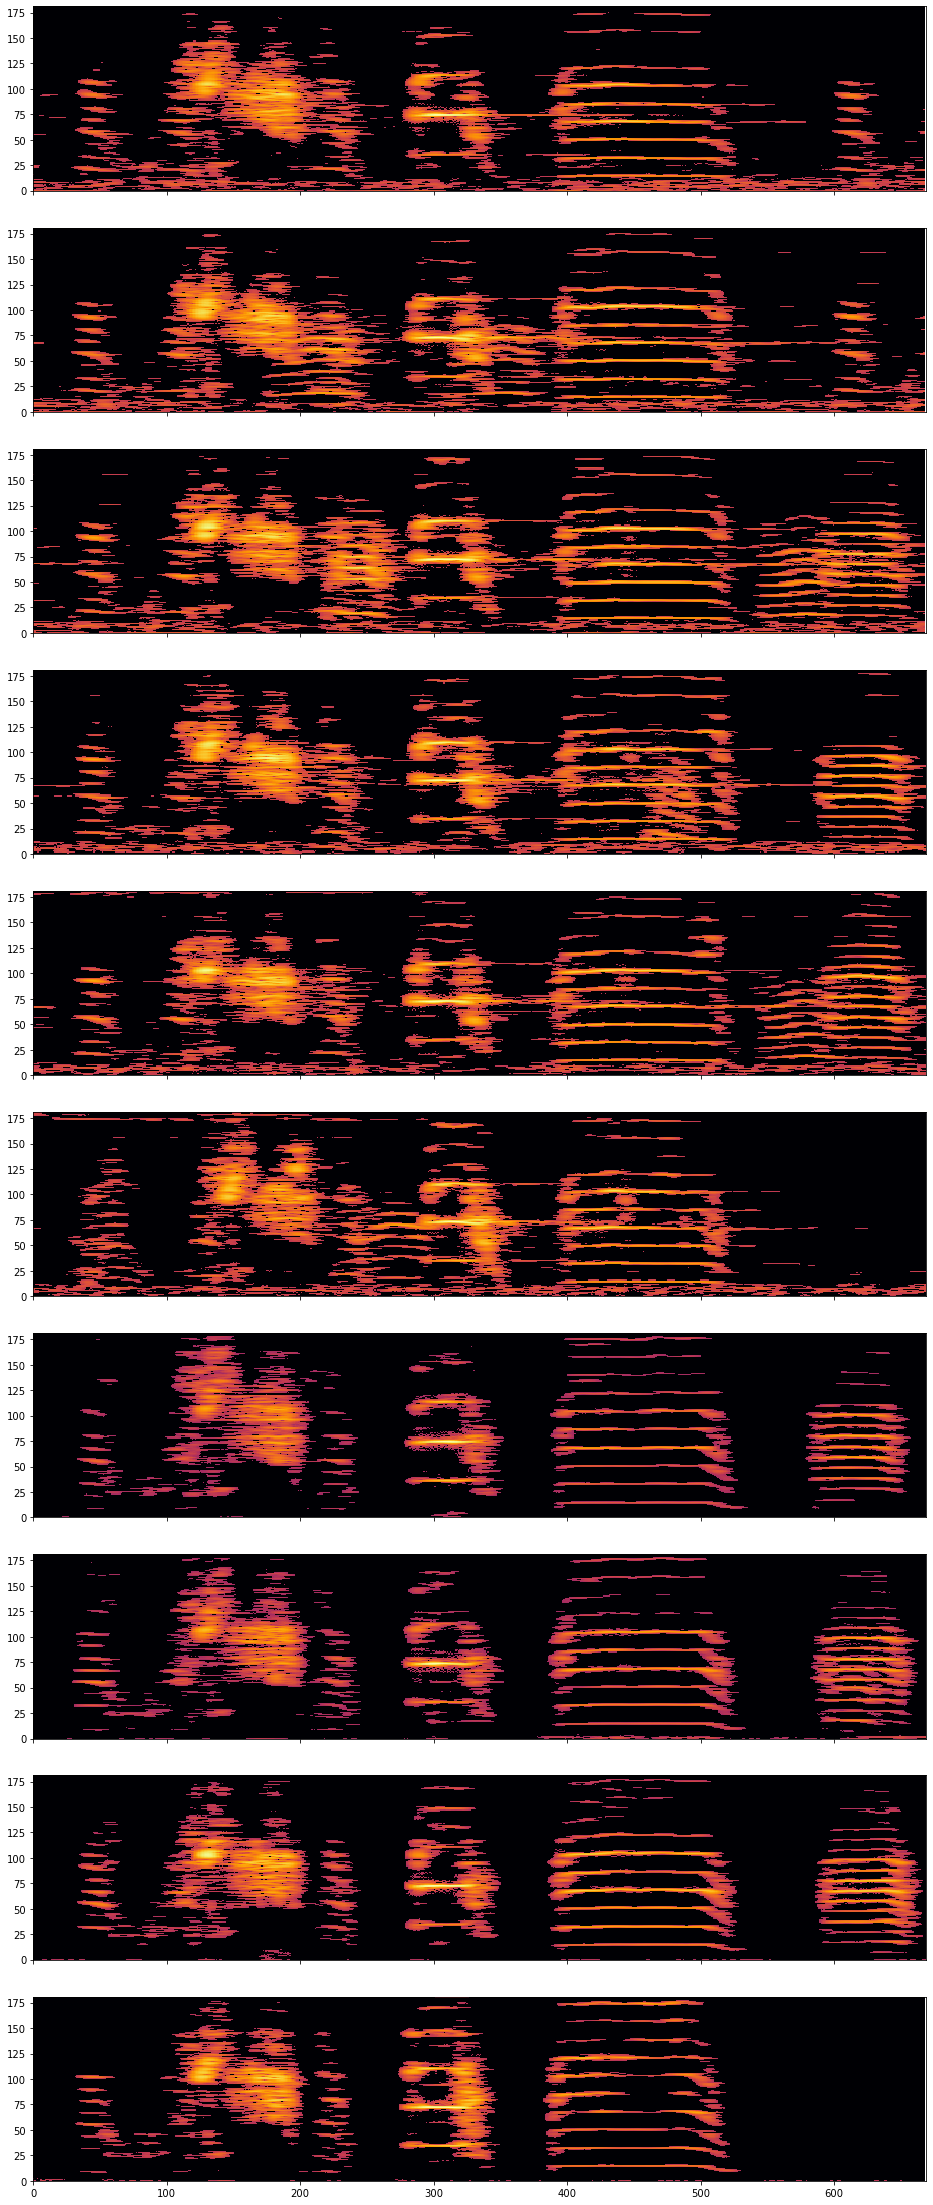

In [71]:
#show_bout = range(n_show)

show_bout = range(10)
n_show = len(show_bout) 
fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

t_pre = bout_dict['t_pre_s']
mot_len_ms = 670

start_in_bout = int(np.abs(t_pre) * 1000) - 40 # in miliseconds, 20 is the spectrogram bin size
end_in_bout = int(start_in_bout + mot_len_ms) # in miliseconds

bout_df['end_in_bout'] = bout_df['t_scale'] * mot_len_ms + start_in_bout


#bout_df['sxx_chop'] = bout_df['sxx'].apply(lambda x: x[:, start_in_bout: end_in_bout])
bout_df['sxx_chop'] = bout_df.apply(lambda x: x['sxx'][:, start_in_bout: int(x['end_in_bout'])],
                                   axis=1)
#bout_df['sxx_chop'] = bout_df.apply(lambda x: x['sxx_chop'][:, :x['len_ms']], axis=1)

def plot_bout(bout_series, ax, cmap='inferno'):
    sxx = bout_series['sxx_chop']
    #print(sxx.shape)
    t = np.arange(sxx.shape[1]) / bout_series['t_scale']
    f = np.arange(sxx.shape[0])
    ax.pcolormesh(t, f, np.log(sxx), cmap=cmap)
    return ax, t

for i_ax, i_bout in enumerate(show_bout):
#     ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx_chop'][::-1]), 
#                     aspect='auto', interpolation='nearest',
#                     cmap='inferno')
    #ax[i_ax].pclormap()
#     sxx = bout_df.iloc[i_bout]['sxx_chop'][::]
#     t = np.arange(sxx.shape[1]) / bout_df.iloc[i_bout]['t_scale']
#     f = np.arange(sxx.shape[0])
#     ax[i_ax].pcolormesh(t, f, np.log(sxx), cmap='inferno')
#     ax[i_ax].set_title('i_bout {}'.format(i_bout))
    plot_bout(bout_df.iloc[i_bout], ax[i_ax])



### get the principal components of the spectrograms

#### make the fit
(normalize the spectrograms, z score et al?)

In [72]:
from sklearn.decomposition import PCA

##### try with one

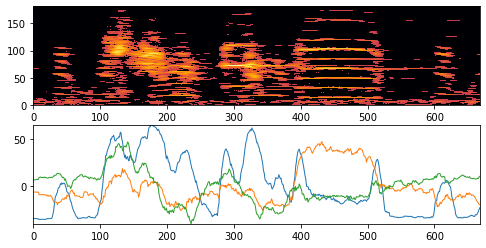

In [75]:
i_bout = 1

x = np.log(bout_df.iloc[i_bout]['sxx_chop'])

pca = PCA(n_components=3, svd_solver='full')
pca.fit(x.T)

y = pca.transform(x.T)

fig, ax = plt.subplots(nrows=2, figsize=(8, 2*2), sharex=False)
ax[0], t = plot_bout(bout_df.iloc[i_bout], ax[0])
ax[1].plot(t, y)

##### make a fit with all the bouts spectrograms


In [65]:
## make a fit with all the bouts spectrograms
pca = PCA(n_components=3, svd_solver='full')

all_x = np.hstack(bout_df['sxx'])
all_x[all_x==np.nan] = 1

pca.fit(np.log(all_x.T))

PCA(n_components=3, svd_solver='full')

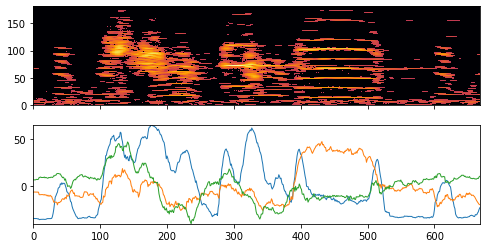

In [77]:
i_bout = 1

x = np.log(bout_df.iloc[i_bout]['sxx_chop'])
y = pca.transform(x.T)
y.shape



fig, ax = plt.subplots(nrows=2, figsize=(8, 2*2), sharex=True)
ax[0], t = plot_bout(bout_df.iloc[i_bout], ax[0])
ax[1].plot(t, y);

#### aply the transform to all

In [76]:
bout_df['spec_pc'] = bout_df['sxx'].apply(lambda x: pca.transform(np.log(x).T))
bout_df['spec_pc_chop'] = bout_df['sxx_chop'].apply(lambda x: pca.transform(np.log(x).T))

In [93]:
## three different motifs (short: ends in silence -with the bout-, long: has an extra syllable, standard: ends with first syllable of next motif)
bout_dict['mot_kind'] = np.array([0, 0, 1, 1, 1, 2, 1, 1, 1, 2])
bout_df['mot_kind'] = bout_dict['mot_kind'] 

In [94]:
bout_df['t_scale'] * mot_len_ms

0    612.920892
1    612.920892
2    616.997972
3    621.075051
4    625.152130
5    670.000000
6    641.460446
7    645.537525
8    653.691684
9    661.845842
Name: t_scale, dtype: float64

In [95]:
bout_df['len_ms']

0    451
1    451
2    454
3    457
4    460
5    493
6    472
7    475
8    481
9    487
Name: len_ms, dtype: int64

In [96]:
bout_df['end_in_bout']

0    5572.920892
1    5572.920892
2    5576.997972
3    5581.075051
4    5585.152130
5    5630.000000
6    5601.460446
7    5605.537525
8    5613.691684
9    5621.845842
Name: end_in_bout, dtype: float64

### gpfa for a bout

In [97]:
def spike_trains_from_bout(bout_s: pd.Series, s_f=30000):
    # get the bout spike array
    spk_arr = bout_s['spk_arr']
    
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

i_bout = 5
bout_spk_trains = spike_trains_from_bout(bout_df.iloc[i_bout])

# get thte spike trains for all bouts
all_bout_idx = list(bout_df.index)
all_spk_trains = [spike_trains_from_bout(bout_df.iloc[i_bout]) for i_bout in all_bout_idx]

### get also the spectrograms
all_spectrograms_list = [bout_df.iloc[i_bout]['sxx'] for i_bout in all_bout_idx]

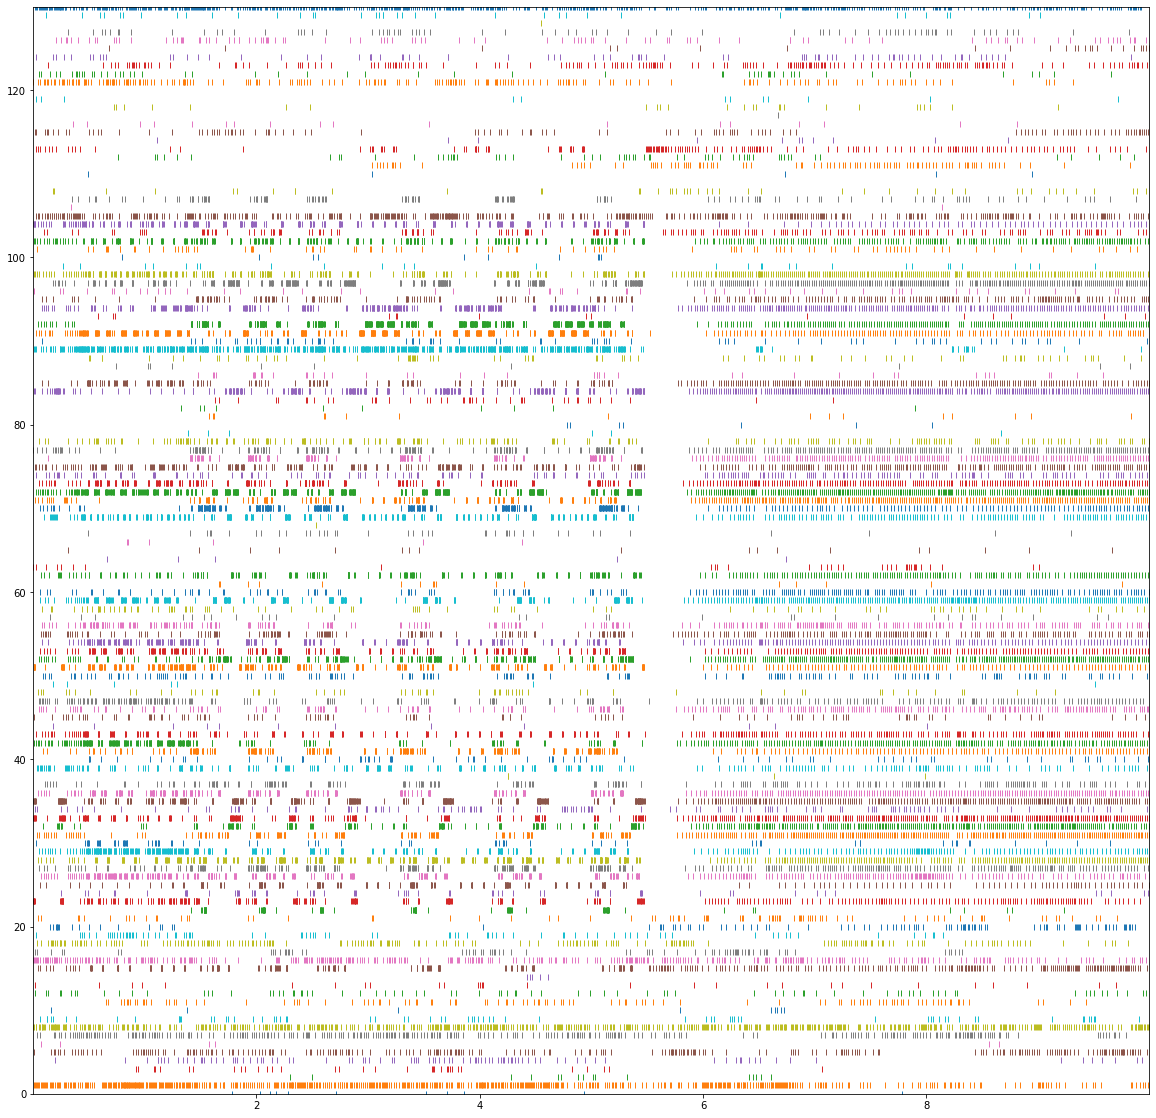

In [98]:
fig, ax = plt.subplots(figsize=(20, 20))

for i, spiketrain in enumerate(bout_spk_trains):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [99]:
import quantities as pq
from elephant.gpfa import GPFA

# specify fitting parameters
bin_ms = 15
bin_size = bin_ms * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [100]:
gpfa_2dim.fit(all_spk_trains)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 23 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 21 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 30 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 24 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [101]:
len(all_spk_trains[0])

131

#### get the trajectories for all the trials now

In [102]:
# get the trajectories for all the trials now
trial_trajectories = gpfa_2dim.transform(all_spk_trains)
# arrange them all into a single array [trial, latent_dim, bin]
trial_trajectories_arr = np.stack(trial_trajectories, axis=0)
trial_trajectories_arr.shape

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 23 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 21 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 30 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 24 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py

(10, 6, 666)

In [137]:
bout_df['gpfa'] = trial_trajectories
bout_df['gpfa'] = bout_df['gpfa'].apply(lambda x: x.T)
plt.plot(bout_df.iloc[0]['gpfa']);

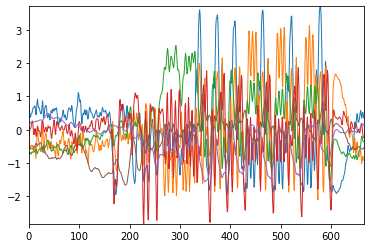

In [103]:
trial_trajectories[0].shape

(6, 666)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f0a375190>)

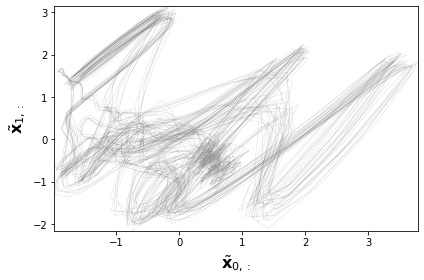

In [104]:
import viziphant as vp
vp.gpfa.plot_trajectories(trial_trajectories, gpfa_2dim, 
                                n_trials_to_plot=5, 
                                plot_group_averages=True)

In [1]:
gpfa_2dim.params_estimated['C']

NameError: name 'gpfa_2dim' is not defined

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f0a25fac0>)

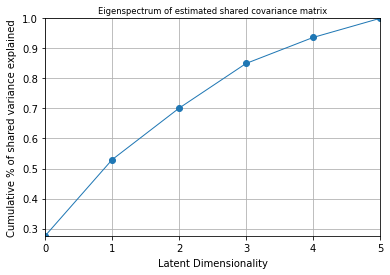

In [107]:
vp.gpfa.plot_cumulative_shared_covariance(gpfa_2dim.params_estimated['C'])

#### chop all trayectories to the motif

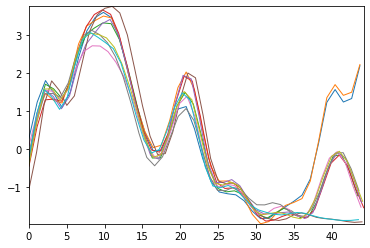

In [141]:
### time warp each to the longest and interpolate
# get the corresponding length and resample interpolate it
mot_start_bin = int(start_in_bout / bin_ms)

traj_list = []
t_list = []

for i_bout, one_trial_traj in enumerate(trial_trajectories):
    bout_s = bout_df.iloc[i_bout]
    one_end_bin = int(bout_s['end_in_bout'] / bin_ms)
    # get the time scale
    # get as many samples of the trajetory starting in start_in_bout
    one_traj = one_trial_traj[:, mot_start_bin: one_end_bin]
    one_t = np.arange(one_traj.shape[1])/bout_s['t_scale']
    plt.plot(one_t, one_traj[0])
    traj_list.append(one_traj)
    t_list.append(one_t)

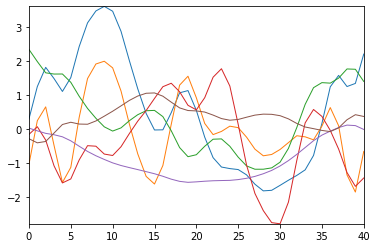

In [142]:
bout_df['gpfa_chop'] = traj_list
bout_df['gpfa_chop'] = bout_df['gpfa_chop'].apply(lambda x: x.T)
plt.plot(bout_df.iloc[0]['gpfa_chop']);

In [109]:
max_traj_len = np.max([x.shape[1] for x in traj_list])
max_traj_len

all_traj_arr = np.stack([signal.resample(x, max_traj_len, axis=1) for x in traj_list], axis=0)

In [110]:
all_traj_arr.shape

(10, 6, 45)

In [111]:
# now it's easy to get the trajectories for the motifs
#mot_trajectories = trial_trajectories[:, :, mot_start_bin: mot_end_bin]
mot_trajectories = all_traj_arr
mot_trajectories.shape

# and the average by 'kind' of motif
avg_traj = [np.median(mot_trajectories[bout_dict['mot_kind']==x], axis=0) for x in np.unique(bout_dict['mot_kind'])]
avg_traj_arr = np.stack(avg_traj, axis=0)

In [112]:
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles

# make a cycle of 10 colors, ordered as the number of different kinds of motifs,
# so that each 'kind' will plot at a unique different color

colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle_list = [colors_pick[i] for i in bout_dict['mot_kind']]

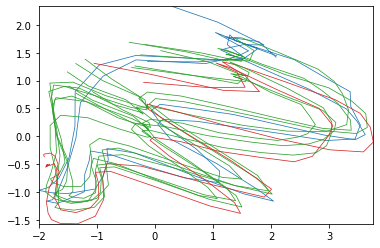

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)

for single_trial_trajectory in mot_trajectories[:]:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[2], '-', lw=0.75)

#ax.plot(avg_trajectories[0], avg_trajectories[1], 'c-.', lw=2);

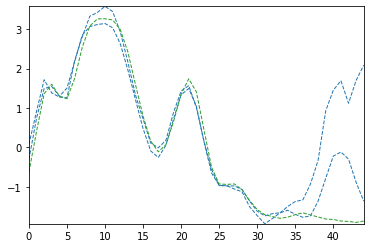

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)
ax.plot(avg_traj_arr[:, 0].T, '--')

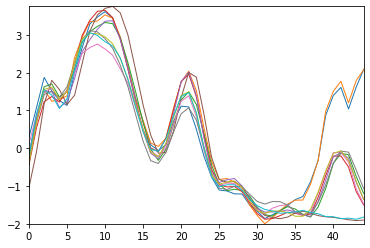

In [115]:
for i, mt in enumerate(mot_trajectories) :
    lc = 0
    plt.plot(mt[0]);

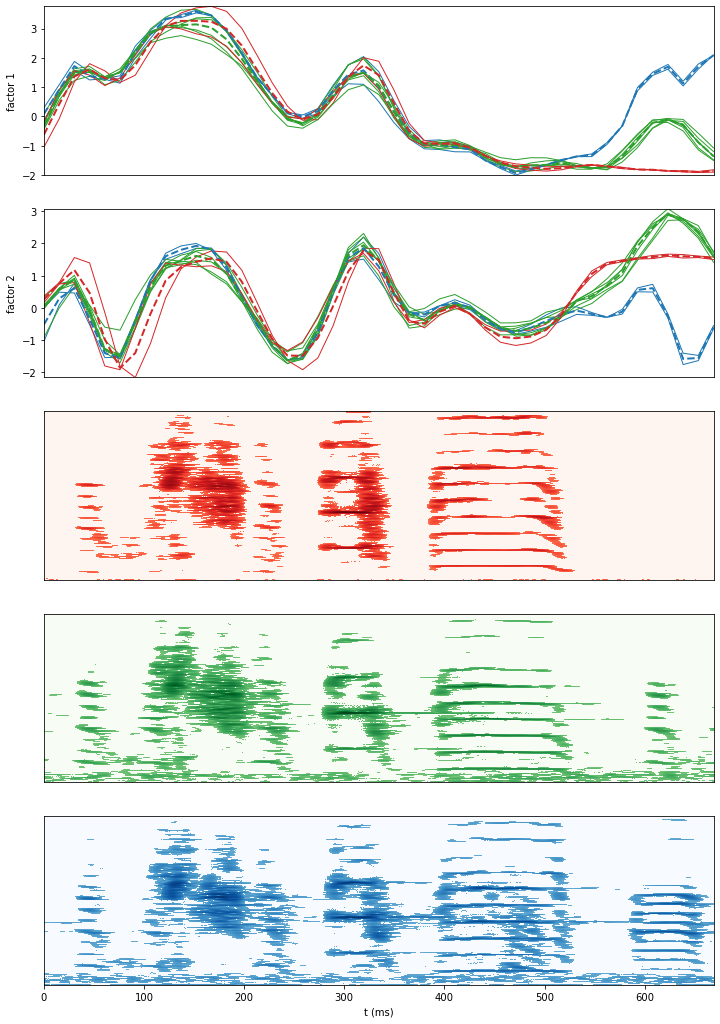

In [116]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
#color_cycle = 
colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle = [colors_pick[i] for i in bout_dict['mot_kind']] + list(colors_pick)

list(map(lambda x: x.set_prop_cycle(color=color_cycle), ax))


ax[0].plot(mot_trajectories[:, 0].T);
ax[0].plot(avg_traj_arr[:, 0].T, '--', lw=2)
ax[0].set_ylabel('factor 1')


ax[1].plot(mot_trajectories[:, 1].T);
ax[1].plot(avg_traj_arr[:, 1].T, '--', lw=2)
ax[1].set_ylabel('factor 2')

# for i in range(3, 6):
#     ax[i].plot(mot_trajectories[:, i].T);
#     ax[i].plot(avg_traj_arr[:, i].T, '--', lw=2)

plot_bout(bout_df.iloc[9], ax[2], cmap='Reds')

plot_bout(bout_df.iloc[0], ax[3], cmap='Greens')

plot_bout(bout_df.iloc[3], ax[4], cmap='Blues')
ax[4].set_xlabel('t (ms)')


for one_ax in ax[:-1]:
    one_ax.set_xlabel('')
    one_ax.set_xticks([])

for one_ax in ax[2:]:
    one_ax.set_yticks([])


In [44]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [158]:
bout_df.head(1)

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,bout_id,t_scale,len,len_scaled,sxx_all,sxx,fr_arr,end_in_bout,sxx_chop,spec_pc,spec_pc_chop,mot_kind,gpfa_chop,gpfa
0,321722,386077,451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-331, -528, -120, -150, -204, -22, 353, 377, ...","[190, 206, 207, 208, 209, 210, 211, 212, 213, ...",321722,0.914807,11275000,12325000.0,"([146.48437499999997, 195.31249999999997, 244....","[[13402.644, 14298.283, 16761.912, 15435.523, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5572.920892,"[[40765.152, 50717.992, 50227.22, 55407.17, 52...","[[-34.246334, -7.966006, 9.229581], [-33.95866...","[[-33.22824, -9.325837, 10.861099], [-33.39089...",0,"[[0.29292632970503063, -1.0392167958921394, 2....","[[0.7457727171961299, -0.12842999767349061, -0..."


## plot a couple

In [ ]:
i_bout = 1

x = np.log(bout_df.iloc[i_bout]['sxx_chop'])

pca = PCA(n_components=3, svd_solver='full')
pca.fit(x.T)

y = pca.transform(x.T)

fig, ax = plt.subplots(nrows=2, figsize=(8, 2*2), sharex=False)
ax[0], t = plot_bout(bout_df.iloc[i_bout], ax[0])
ax[1].plot(t, y)

## compare the PCA distances and the GPFA distances

In [196]:
from sklearn.metrics.pairwise import cosine_similarity
# for one against all
def cosine_norm(x, y):
    cos_arr = cosine_similarity(x, y)
    cos_norm = np.linalg.norm(np.diagonal(cos_arr))
    return cos_norm

def cosine_sum(x, y):
    cos_arr = cosine_similarity(x, y)
    cos_norm = np.trace(cos_arr)
    return cos_norm

def distance_to_others(bout_df, i_bout, feature='spec_pc_chop'):
    
    one_series = bout_df.iloc[i_bout][feature]
    
    distances = bout_df[feature].apply(lambda x: cosine_similarity(one_series, x))
    return distances

def all_dist_array(bout_df, feature):
    dist_list = [distance_to_others(bout_df, i, feature) for i in bout_df.index]
    return np.vstack(dist_list)

all_dist_one = distance_to_others(bout_df, 1, 'spec_pc_chop')

In [198]:
all_dist_one[0].shape

(612, 612)

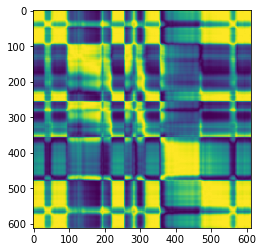

In [199]:
plt.imshow(all_dist_one[0])

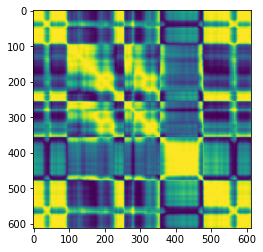

In [200]:
plt.imshow(all_dist_one[1])

In [202]:
all_dist_one_gpfa = distance_to_others(bout_df, 1, 'gpfa_chop')

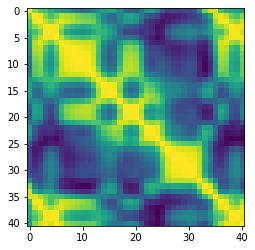

In [203]:
plt.imshow(all_dist_one_gpfa[1])

In [190]:
all_dist_one_pca = distance_to_others(bout_df, 1, 'spec_pc_chop')
all_dist_one_gpfa = distance_to_others(bout_df, 1, 'gpfa_chop')

###### now make a pca with the same bin size as the gpfa

In [317]:
bout_df['pca_bin'] = bout_df['spec_pc_chop'].apply(lambda y: pu.col_binned(y.T, bin_ms).T)

bout_df['pca_gauss'] = bout_df['pca_bin'].apply(lambda y: gaussian_filter1d(y, 1, axis=0))


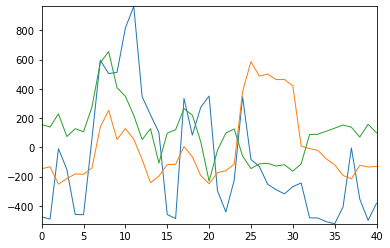

In [318]:
plt.plot(bout_df.loc[0, 'pca_bin'])

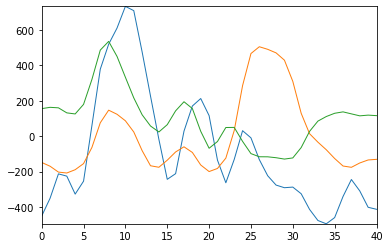

In [319]:
plt.plot(bout_df.loc[0, 'pca_gauss'])

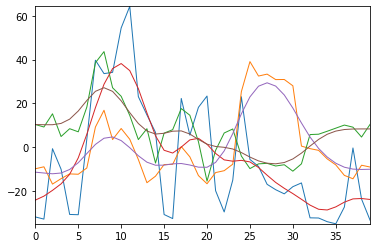

In [320]:
## gaussian filter one pc array


pc_gauss = gaussian_filter1d(pc_arr, sigma=2, axis=0)

plt.plot(pc_arr)
plt.plot(pc_gauss)


### get all the distances

In [321]:
all_dist_pca = all_dist_array(bout_df, 'spec_pc_chop')
all_dist_pca_bin = all_dist_array(bout_df, 'pca_bin')
all_dist_pca_gauss = all_dist_array(bout_df, 'pca_gauss')
all_dist_gpfa= all_dist_array(bout_df, 'gpfa_chop')

In [322]:
all_dist_gpfa[1][0]

array([[0.81146378, 0.74609082, 0.51191781, ..., 0.39423125, 0.2939588 ,
        0.22172076],
       [0.64425957, 0.96475308, 0.96533148, ..., 0.58002519, 0.46363598,
        0.68897941],
       [0.63384891, 0.92033293, 0.9754277 , ..., 0.74630041, 0.65856462,
        0.87601993],
       ...,
       [0.75620678, 0.67092448, 0.67168819, ..., 0.98495803, 0.9706963 ,
        0.93925497],
       [0.72573782, 0.58006618, 0.57883652, ..., 0.98659554, 0.99026181,
        0.92039473],
       [0.58586326, 0.68587055, 0.77723824, ..., 0.910823  , 0.8882374 ,
        0.99467699]])

In [323]:
all_dist_gpfa[1][0].shape

(41, 41)

In [324]:
all_dist_pca_gauss[1][0].shape

(41, 41)

### get the upper triangle

##offset/shift the arrays

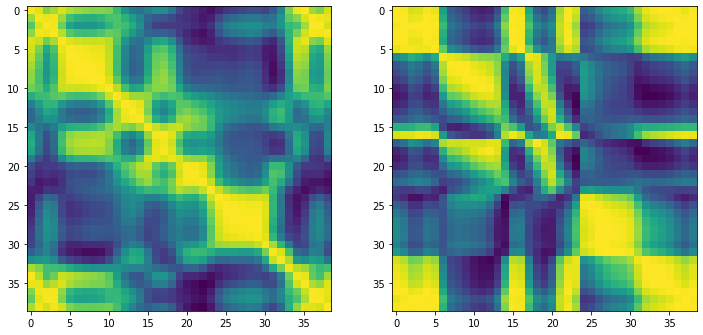

In [388]:
lag = 2

gpfa_corr = all_dist_gpfa[1][0][lag:, lag:]
pca_corr = all_dist_pca_gauss[1][0][:-lag, :-lag]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 18))

ax[0].imshow(gpfa_corr)
ax[1].imshow(pca_corr)

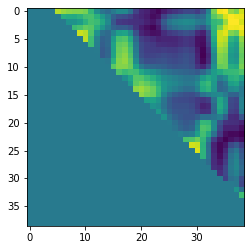

In [391]:
plt.imshow(np.triu(gpfa_corr, 5))

(-1.0, 1.0)

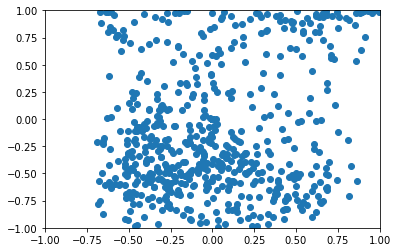

In [398]:
plt.scatter(np.triu(gpfa_corr, 5), np.triu(pca_corr, 5));
plt.ylim([-1, 1])
plt.xlim([-1, 1])

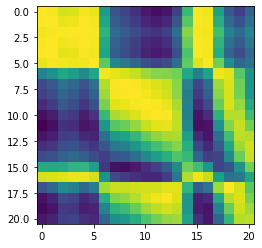

In [370]:
plt.imshow(all_dist_pca_gauss[1][0][:-20, :-20])

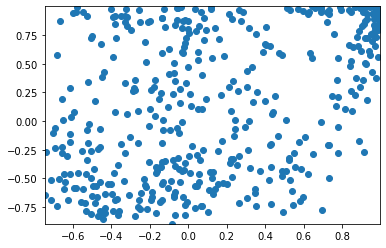

In [371]:
plt.scatter(all_dist_gpfa[1][0][20:, 20:], all_dist_pca_gauss[1][0][:-20, :-20])

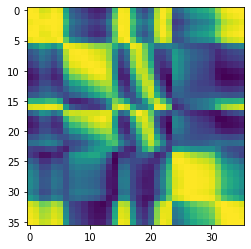

In [356]:
plt.imshow(all_dist_pca_gauss[1][0][:-5, :-5])

(-1.0, 1.0)

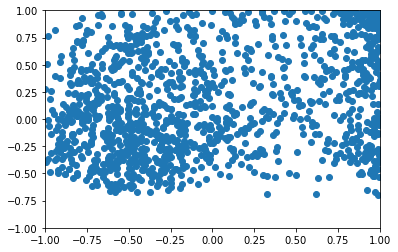

In [352]:
plt.scatter((all_dist_pca_gauss[1][0][5:, 5:]), (all_dist_gpfa[1][0][:-5, :-5]))
plt.xlim([-1, 1])
plt.ylim([-1, 1])

In [364]:
import scipy
pca_gpfa_corr = scipy.signal.correlate2d(all_dist_pca_gauss[1][0], all_dist_gpfa[1][0])

In [367]:
np.trace(pca_gpfa_corr)

6452.7918980635895

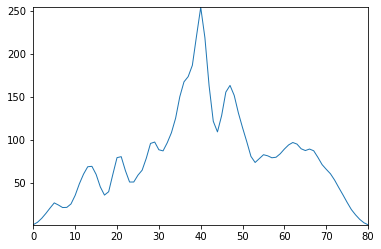

In [368]:
plt.plot(np.diag(pca_gpfa_corr))

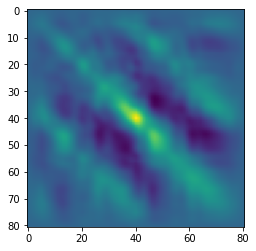

In [365]:
plt.imshow(pca_gpfa_corr)

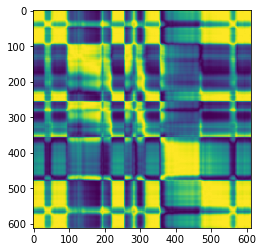

In [259]:
plt.imshow(all_dist_pca[1][0])

Text(0, 0.5, 'GPF similarity')

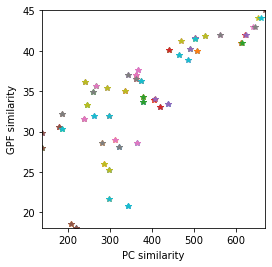

In [195]:
all_dist_pca = all_dist_array(bout_df, 'spec_pc_chop')
all_dist_gpfa= all_dist_array(bout_df, 'gpfa_chop')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(all_dist_pca, all_dist_gpfa, '*', lw=1)
ax.set_xlabel('PC similarity')
ax.set_ylabel('GPF similarity')



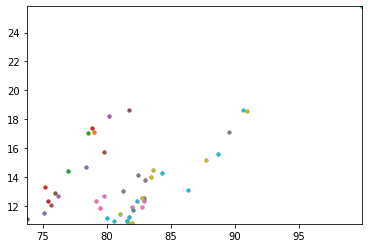

In [178]:
all_dist_pca = all_dist_array(bout_df, 'spec_pc')
all_dist_gpfa= all_dist_array(bout_df, 'gpfa')
plt.plot(all_dist_pca, all_dist_gpfa, '.')

### save trajectories

In [117]:
exp_struct['folders']['sort']

'/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4'

In [118]:
traj_file_path = os.path.join(exp_struct['folders']['sort'], 'ra_gpfa.pickle')
traj_dict = {'mot_trajectories': mot_trajectories,
            'avg_traj_arr': avg_traj_arr,
            'trial_trajectories_list': trial_trajectories}

with open(traj_file_path, 'wb') as f:
    pickle.dump(traj_dict, f)
    
traj_file_path

PermissionError: [Errno 13] Permission denied: '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/ra_gpfa.pickle'

### pick these two particular bouts

In [121]:
bout_i_list = [1, 5, 3]
bout_id_list = [bout_df.iloc[i]['bout_id'] for i in bout_i_list]

In [122]:
### pick a random sample of bouts
umap_win = 50
n_sample = 2

#all_bout_id = bout_df['bout_id'].values

id_some_bout = np.array(bout_id_list)
#id_some_bout = np.random.choice(all_bout_id, n_sample, replace=False)

### make the projection with just this set of bouts
feature = 'sxx' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.

## save/load the reducer
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

sx_reducer = make_umap_from_sample(bout_df, some_bout_id=id_some_bout, window_size=umap_win)

with open(reducer_path, 'wb') as f:
    pickle.dump(sx_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))
    
## or alternatively load reducer

NameError: name 'make_umap_from_sample' is not defined

In [ ]:
feature = 'sxx'
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))
reducer_path

In [ ]:
bout_df = project_bouts(bout_df, id_some_bout, sx_reducer, window_size=umap_win)

In [ ]:
feature = 'fr_arr' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

# maybe load reducer instead of computing it
fr_reducer = make_umap_from_sample(bout_df, feat=feature, some_bout_id=id_some_bout, window_size=umap_win)

#save reducer
with open(reducer_path, 'wb') as f:
    pickle.dump(fr_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))


bout_df = project_bouts(bout_df, id_some_bout, fr_reducer, window_size=umap_win, feat=feature)

In [ ]:
### load/save the bouts with projected umap

In [ ]:

bout_df.to_pickle(umap_bout_df_path)
logger.info('saved bout_df to {}'.format(umap_bout_df_path))

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[0]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[1]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[2]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
for bout_id in bout_id_list:
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]
    
    bout_df.loc[bout_df['bout_id']][]

In [ ]:
def show_bout(bout_df, bout_id, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 16))
        gs = fig.add_gridspec(4, 4)
        ax = []
        ax.append(fig.add_subplot(gs[0, :]))
        ax.append(fig.add_subplot(gs[1, :]))
        ax.append(fig.add_subplot(gs[2:, :2]))
        ax.append(fig.add_subplot(gs[2:, 2:]))
    
        
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]

    sx = the_bout['sxx'].values[0]
    emb_sx = the_bout['rolled_umap_sxx'].values[0]
    emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

    ax[0].imshow(np.log(the_bout['sxx'].values[0][::-1]), aspect='auto', cmap='inferno');
    ax[1].imshow((the_bout['fr_arr'].values[0][::-1]), aspect='auto', cmap='inferno');
    
    ax[2].scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='coolwarm');
    ax[3].scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');
                           
    return ax
                           
show_bout(bout_df, bout_id_list[0])

In [ ]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 



In [19]:
3396144552/(12)

283012046.0

In [20]:
3396144552/(12*24999.666109)

11320.633034299377

In [22]:
261485552790/(385*2)

339591627.0

In [23]:
261485552790/(385*2*29999.905882)

11319.75641309447

In [21]:
21791246400/(385*2*2499.9921568333334)

11320.163514371654

In [16]:
21791246400/(385*2)

20895856.0